In [1]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from apelfei.statistics import fpf_2_gaussian_sigma, gaussian_sigma_2_fpf, TTest, LaplaceBootstrapTest
from apelfei.contrast import ContrastResults, collect_all_data_setup_configs, estimate_stellar_flux
from apelfei.utils.aperture_positions import get_number_of_apertures

Found installation of parallel_sort and use it.


## This code is about:

This code computes the required SNR needed for a 5sigma / 3 sigma detection as a function of separation. The result is the plot 09 in the paper part 1.

## Set colors used in the plot

In [2]:
color_palette = [sns.color_palette("colorblind")[0],
                 sns.color_palette("colorblind")[1]]

color_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549)]

# Create the test statistic instances

In [3]:
ttest_statistic = TTest(1)

In [4]:
pbs_laplace_statistic = LaplaceBootstrapTest.construct_from_json_file(
    "../apelfei/statistics/lookup_tables/laplace_lookup_tables.csv")

## Get the data of interest

In [5]:
separation_lambda_D = 20
ttest_statistic.fpf2tau(gaussian_sigma_2_fpf(5), get_number_of_apertures(2*separation_lambda_D, 1) - 1 )

5.2767977414283775

In [6]:
separation_lambda_D = np.arange(1, 20.5, 0.5)
num_noise_values = [get_number_of_apertures(2*i, 1) - 1 for i in separation_lambda_D]

In [7]:
req_snr_ttest3 = []
req_snr_laplace3 = []
req_snr_ttest5 = []
req_snr_laplace5 = []

for tmp_num_noise in num_noise_values:
    tmp_req_snr_ttest3 = ttest_statistic.fpf2tau(gaussian_sigma_2_fpf(3), 
                                                 tmp_num_noise)
    
    tmp_req_snr_laplace3 = pbs_laplace_statistic.fpf2tau(gaussian_sigma_2_fpf(3), 
                                                tmp_num_noise)
    
    req_snr_ttest3.append(tmp_req_snr_ttest3)
    req_snr_laplace3.append(tmp_req_snr_laplace3)
    
    tmp_req_snr_ttest5 = ttest_statistic.fpf2tau(gaussian_sigma_2_fpf(5), 
                                                 tmp_num_noise)
    
    tmp_req_snr_laplace5 = pbs_laplace_statistic.fpf2tau(gaussian_sigma_2_fpf(5), 
                                                tmp_num_noise)
    
    req_snr_ttest5.append(tmp_req_snr_ttest5)
    req_snr_laplace5.append(tmp_req_snr_laplace5)

In [8]:
req_snr_ttest5[::2][9]

5.596465609911393

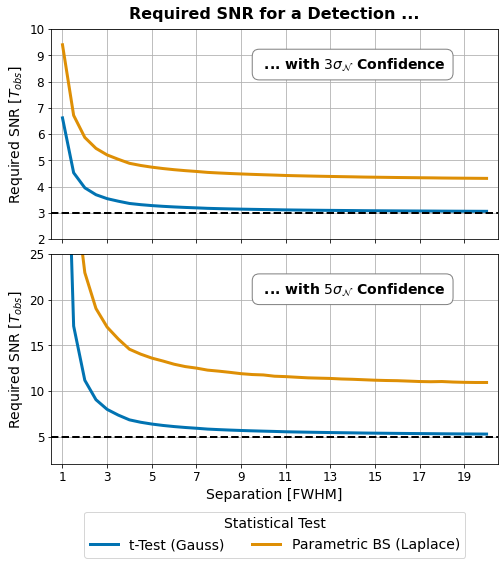

In [10]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
gs0 = fig.add_gridspec(2, 1)
gs0.update(hspace=0.07, wspace=0.09)

axis_rq_snr3 = fig.add_subplot(gs0[0, 0])
axis_rq_snr5 = fig.add_subplot(gs0[1, 0])

# 2.) Make the plot 3 sigma
def plot_snr(results_ttest,
             results_laplace,
             confidence,
             axis_in):
    axis_in.plot(separation_lambda_D, 
                 results_ttest, 
                 label="t-Test (Gauss)",
                 color=color_palette[0],
                 lw=3)

    axis_in.plot(separation_lambda_D, 
                 results_laplace, 
                 label="Parametric BS (Laplace)",
                 color=color_palette[1],
                 lw=3)
    
    axis_in.axhline(confidence, lw=2, ls="--", color="black")
    axis_in.grid()
    
    if confidence == 5:
        a = 20.7
    else:
        a = 8.5
    
    axis_in.text(14, a, r" ... with ${} \sigma_{{\mathcal{{N}}}}$ Confidence".format(str(confidence)),
                 ha="center", fontsize=14, fontweight="bold",
                 bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    
plot_snr(req_snr_ttest3, req_snr_laplace3, 3, axis_rq_snr3)
plot_snr(req_snr_ttest5, req_snr_laplace5, 5, axis_rq_snr5)

# 3.) Set limits
axis_rq_snr5.set_ylim(2, 25)
axis_rq_snr5.set_xlim(0.5, 20.5)

axis_rq_snr3.set_ylim(2, 10)
axis_rq_snr3.set_xlim(0.5, 20.5)

axis_rq_snr3.set_xticks(np.arange(1, 20, 2))
axis_rq_snr5.set_xticks(np.arange(1, 20, 2))

axis_rq_snr3.tick_params(axis='both', which='major', labelsize=12)
axis_rq_snr5.tick_params(axis='both', which='major', labelsize=12)

# 4.) Set Labels
plt.setp(axis_rq_snr3.get_xticklabels(), visible=False)

axis_rq_snr5.set_xlabel(r"Separation [FWHM]", size=14)
axis_rq_snr5.set_ylabel(r"Required SNR [$T_{obs}$]", size=14)
axis_rq_snr3.set_ylabel(r"Required SNR [$T_{obs}$]", size=14)

axis_rq_snr3.set_title("Required SNR for a Detection ...",
                         fontsize=16, fontweight="bold", y=1.02)

# 5.) Legend
handles, labels = axis_rq_snr5.get_legend_handles_labels()
leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.17, -0.05), 
                  fontsize=14, 
                  title="Statistical Test",
                  loc='lower left', ncol=2)
plt.setp(leg1.get_title(),fontsize=14)

# 5.) Save the Plot
fig.patch.set_facecolor('white')
plt.savefig("./09_Required_SNR.pdf", 
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')